# Определение возраста покупателей

## Цели и ход поекта

В данном проекте мы создадим систему компьютерного зрения для обработки фотографий покупателей в прикассовой зоне сетевого супермаркета. 

**Цель проекта:**
Построить модель, которая по фотографии определит возраст клиентов.

В качестве датасета будет использован набор фотографий людей с указанием возраста.

**Ход исследвания:**
- Исследовательский анализ данных
- Обучение модели 
- Анализ и выводы

## Исследовательский анализ данных

In [5]:
# Импортируем библиотеки

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Загружаем данные

labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


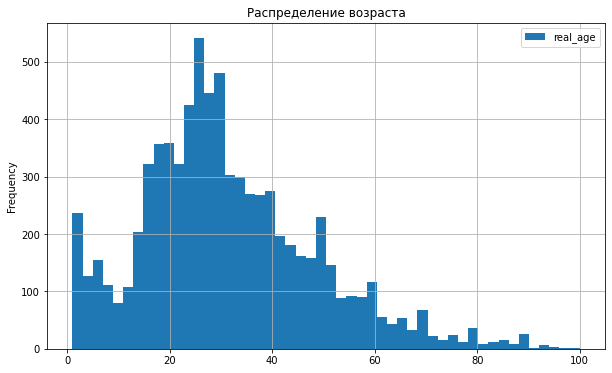

In [3]:
# Построим распределение возраста в выборке
labels.plot(kind='hist', bins=50, figsize=(10,6), grid='true', title='Распределение возраста');

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


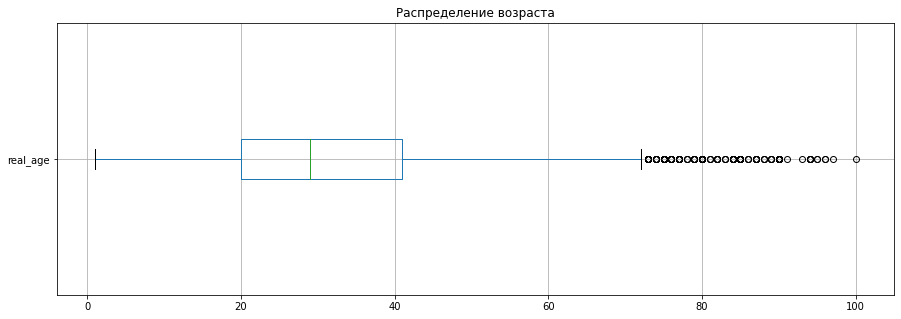

In [5]:
labels.plot.box(figsize=(15,5), vert=False, grid='true', title='Распределение возраста');

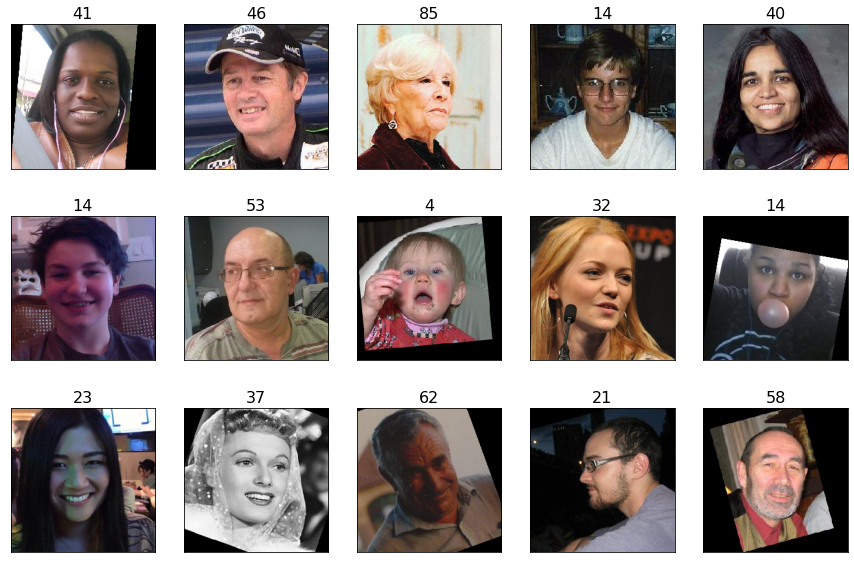

In [8]:
# Напечатаем 15 снимков из датасета с указанием возраста

batch, label = next(datagen_flow)

plt.figure(figsize=[15, 10])

for i in range(1, 16):
    plt.subplot(3, 5, i)
    image = batch[i]
    plt.xticks([])
    plt.yticks([])
    plt.title(label[i], fontsize = 16)
    plt.imshow(image)

**Вывод:**

В датасете 7591 изображений людей разных возрастов: от годовалых младенцев до 100-летних долгожителей. 

Средний возраст изображенных людей 31 год, медианный - 29 лет. 

Распределение скошено вправо. Возраста страше 72 образуют выбросы.

Можно предположить, что поскольку данных о пожилых людях мало, то модели будет сложнее определять эти возраста.

На снимках изображены люди разной расовой принадлежности.

В датасете представлены как черно-белые, так и цветные фотографии разного качества и разных эпох, сделанных с разных ракурсов. 

Это может усложить задачу модели, но в то же время повысить ее качество. В реальных условиях модель будет предсказывать по снимкам примерно одинакового качества, сделанным в прикассовой зоне.

## Обучение модели

```python

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

optimizer = Adam(learning_rate=0.0001)

def load_train(path):
    
    labels = pd.read_csv(path + '/labels.csv')
    
    train_datagen = ImageDataGenerator(
                                       validation_split=0.25,
                                       rescale=1/255,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2
                                       )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
                                                       dataframe=labels,
                                                       directory=path + '/final_files',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345
                                                       )                               
    return train_gen_flow

def load_test(path):
    
    labels = pd.read_csv(path + '/labels.csv')
    
    test_datagen = ImageDataGenerator(
                                      validation_split=0.25,
                                      rescale=1/255
                                      )
    
    test_gen_flow = test_datagen.flow_from_dataframe(
                                                     dataframe=labels,
                                                     directory=path + '/final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345
                                                     )                   
    
    return test_gen_flow
                                 
def create_model(input_shape):
    
    backbone = ResNet50(
                        input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False
                        )
                                 
    model = Sequential()                            
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error'])    

    return model
    
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=5,
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(
              train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True
              )

    return model 

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/5
178/178 - 114s - loss: 239.4474 - mean_absolute_error: 11.1959 - val_loss: 648.4936 - val_mean_absolute_error: 20.4845

Epoch 2/5
178/178 - 97s - loss: 85.2512 - mean_absolute_error: 6.9534 - val_loss: 642.0463 - val_mean_absolute_error: 20.1665

Epoch 3/5
178/178 - 97s - loss: 60.5792 - mean_absolute_error: 5.9392 - val_loss: 220.3753 - val_mean_absolute_error: 10.9972

Epoch 4/5
178/178 - 105s - loss: 46.5080 - mean_absolute_error: 5.2581 - val_loss: 148.2042 - val_mean_absolute_error: 8.8141

Epoch 5/5
178/178 - 106s - loss: 37.4000 - mean_absolute_error: 4.6966 - val_loss: 86.5000 - val_mean_absolute_error: 6.9440

60/60 - 12s - loss: 86.5000 - mean_absolute_error: 6.9440

Test MAE: 6.9440

```

## Анализ обученной модели

Для предсказания возраста по фоторафиям мы выбрали предобученную на ImageNet сеть ResNet50, главная особенность которой заключается в использовании Shortcut Connections для решения проблемы затухающего градиента.

Мы не замораживали сеть, так как данных было достаточно для полноценного обучения.

Мы поделили данные на тренировочную и тестовую выборки в пропорции 75:25, применили сдвиги изображений по вертикали и горизонтали на 20% от исходного размера, определили размер батча равным 32.

В качестве функции потерь использовали MSE, в качестве метики качества - MAE.

Мы обучили модель на 5 эпохах. Итоговое значение метрики на тестовой выборке составило **6.9**.

**Вывод:**

Модель ResNet50, предобученная на датасете ImageNet подходит для решения задачи предсказания возраста.